# Phase 4 — Baseline Models & Evaluation

Train multiple classical ML models, evaluate, and save the best baseline model.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import joblib
from pathlib import Path

# Paths
DATA_DIR = Path("../data/processed/ml_balance")
MODEL_DIR = Path("../trained_models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Load balanced data
X = pd.read_csv(DATA_DIR / "train_balanced.csv")
y = pd.read_csv(DATA_DIR / "train_balanced_labels.csv")

# Ensure y is a flat Series
if y.shape[1] == 1:
    y = y.iloc[:, 0]  # convert to Series

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=10, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, use_label_encoder=False,
        eval_metric='mlogloss'
    ),
    "LogisticRegression": LogisticRegression(max_iter=500),
    "LightGBM": LGBMClassifier(n_estimators=300, random_state=42)
}

# Train and evaluate
results = {}
for name, clf in models.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    print(f"{name} classification report:\n")
    print(classification_report(y_val, preds))
    f1 = f1_score(y_val, preds, average='weighted')
    results[name] = {'f1': f1, 'model': clf}

# Pick best baseline model
best_name = max(results, key=lambda k: results[k]['f1'])
print("\nBest baseline:", best_name, "F1:", results[best_name]['f1'])

# Save best baseline
joblib.dump(results[best_name]['model'], MODEL_DIR / "best_baseline.pkl")
print(f"Saved best baseline to {MODEL_DIR / 'best_baseline.pkl'}")



Training RandomForest...
RandomForest classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20000
           1       1.00      1.00      1.00      4000
           2       1.00      1.00      1.00     20484
           3       1.00      1.00      1.00      4000
           4       1.00      1.00      1.00     36820
           5       1.00      1.00      1.00      4000
           6       1.00      1.00      1.00      4000
           7       1.00      1.00      1.00      4000
           8       1.00      1.00      1.00      4000
           9       1.00      1.00      1.00      4000
          10       1.00      1.00      1.00     25409
          11       1.00      1.00      1.00      4000
          12       0.95      0.95      0.95      4000
          13       1.00      1.00      1.00      4000
          14       0.95      0.95      0.95      4000

    accuracy                           1.00    146713
   macro avg     

d:\project\unified-ids-and-iot-security-system\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:58:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20000
           1       1.00      1.00      1.00      4000
           2       1.00      1.00      1.00     20484
           3       1.00      1.00      1.00      4000
           4       1.00      1.00      1.00     36820
           5       1.00      1.00      1.00      4000
           6       1.00      1.00      1.00      4000
           7       1.00      1.00      1.00      4000
           8       1.00      1.00      1.00      4000
           9       1.00      1.00      1.00      4000
          10       1.00      1.00      1.00     25409
          11       1.00      1.00      1.00      4000
          12       0.91      0.89      0.90      4000
          13       1.00      1.00      1.00      4000
          14       0.89      0.92      0.91      4000

    accuracy                           0.99    146713
   macro avg       0.99      0.99      0.99    1

d:\project\unified-ids-and-iot-security-system\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression classification report:

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     20000
           1       0.88      0.75      0.81      4000
           2       0.99      1.00      0.99     20484
           3       0.98      0.96      0.97      4000
           4       0.98      1.00      0.99     36820
           5       0.98      0.98      0.98      4000
           6       0.98      0.96      0.97      4000
           7       0.98      1.00      0.99      4000
           8       1.00      1.00      1.00      4000
           9       0.98      0.97      0.97      4000
          10       0.99      1.00      0.99     25409
          11       0.87      0.85      0.86      4000
          12       0.70      0.42      0.53      4000
          13       0.77      0.94      0.85      4000
          14       0.59      0.81      0.68      4000

    accuracy                           0.95    146713
   macro avg       0.91      0.90    

d:\project\unified-ids-and-iot-security-system\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\project\unified-ids-and-iot-security-system\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\project\unified-ids-and-iot-security-system\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod


Best baseline: RandomForest F1: 0.9965784803928903
Saved best baseline to ..\trained_models\best_baseline.pkl


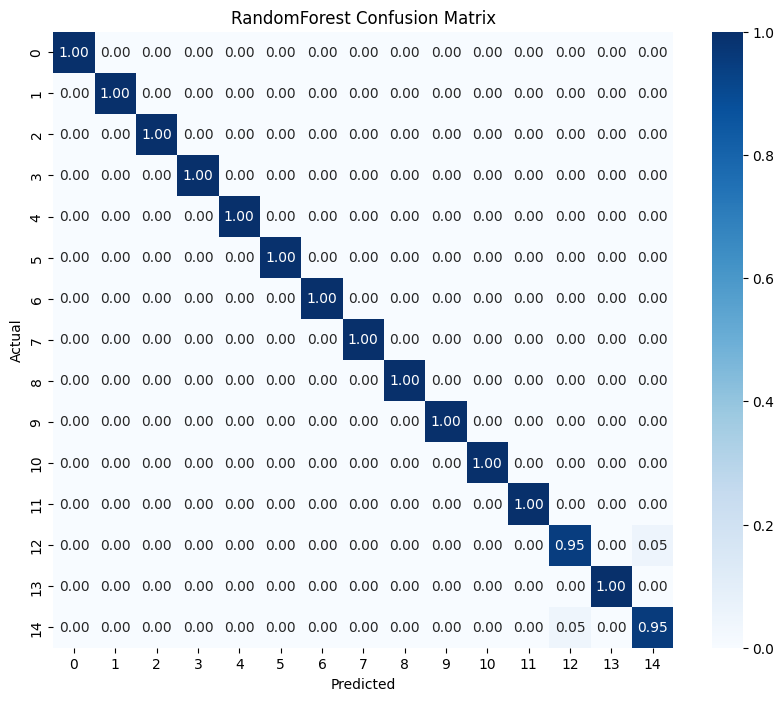

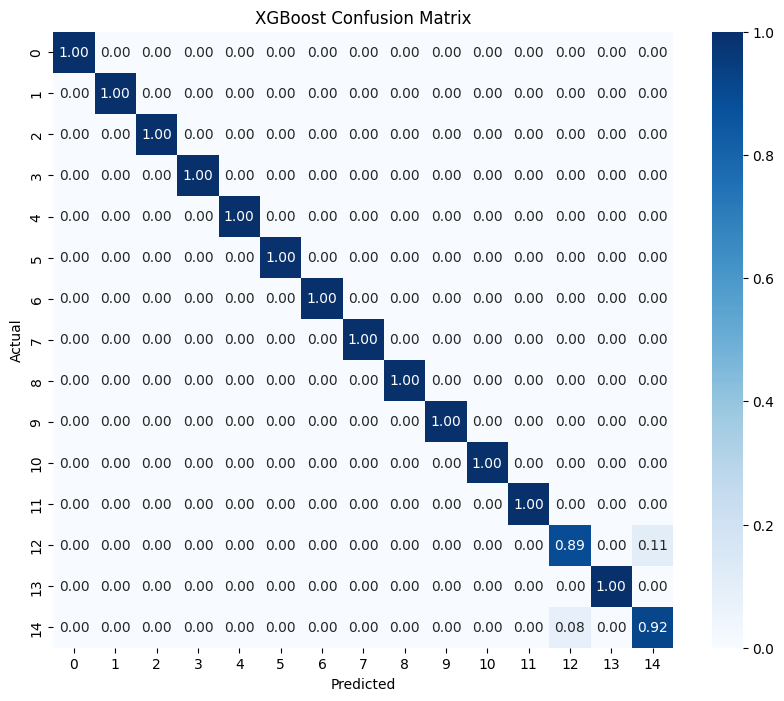

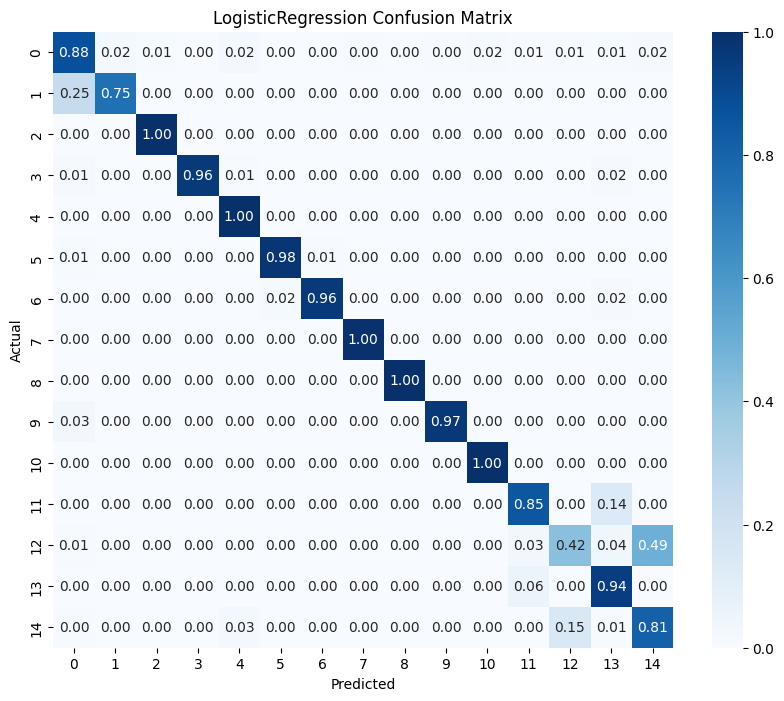

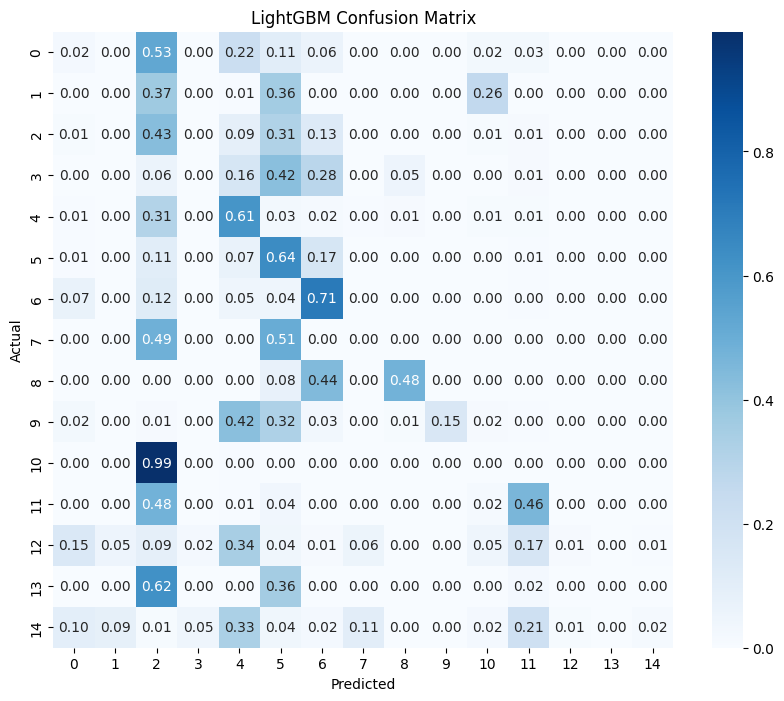

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_labels=None, title="Confusion Matrix", figsize=(10,8)):
    """
    Plots a confusion matrix with annotations.

    Parameters:
        y_true: array-like of shape (n_samples,)
        y_pred: array-like of shape (n_samples,)
        class_labels: list of labels for x/y axes (optional)
        title: title of the plot
        figsize: tuple for figure size
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize per row

    plt.figure(figsize=figsize)
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


# Example usage for all models
class_labels = sorted(y_train.unique())  # numeric or string labels

for name, res in results.items():
    clf = res['model']
    preds = clf.predict(X_val)
    plot_confusion_matrix(y_val, preds, class_labels=class_labels, title=f"{name} Confusion Matrix")
